In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Reshape, LeakyReLU, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.decomposition import PCA
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


### PCA:
- para ver a distribuição dos dados, estes serão reduzidos à só dois dimensões com PCA.

In [3]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [4]:
X_pca = pca.transform(X_train)
print("Dimensionalidade: ", X_pca.shape)

Dimensionalidade:  (4051, 2)


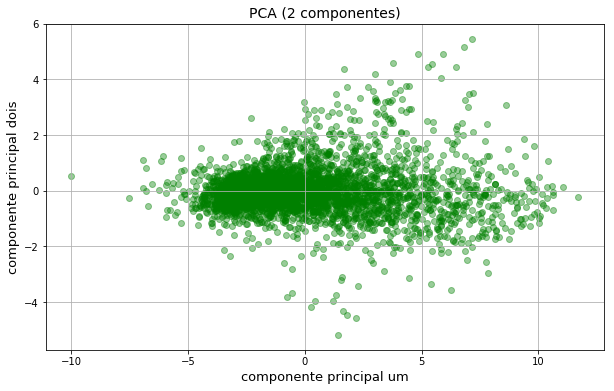

In [5]:
plt.figure(figsize=(10,6))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], color="green", alpha=.4);

### Normalização dos dados
- Para poder fazer uso das GAN's, a gente tem que normalizar os dados, para eso é usada a seguinte normalização:
<br><br>
$$X = \frac{x_{i} - mean(X)}{mean(X)}$$

In [6]:
X_train = (X_train - np.mean(X_train))/np.mean(X_train)

- vou trocar a dimensionalidade de cada gen, por uma dimesionalidade de 3x3, para assim ver o gen como uma matrix.

In [7]:
X_img = np.array(X_train).reshape((X_train.shape[0],3,3,1))
X_lab = X_train.index

----------------------------- Genomas representados na forma de uma matriz -----------------------------


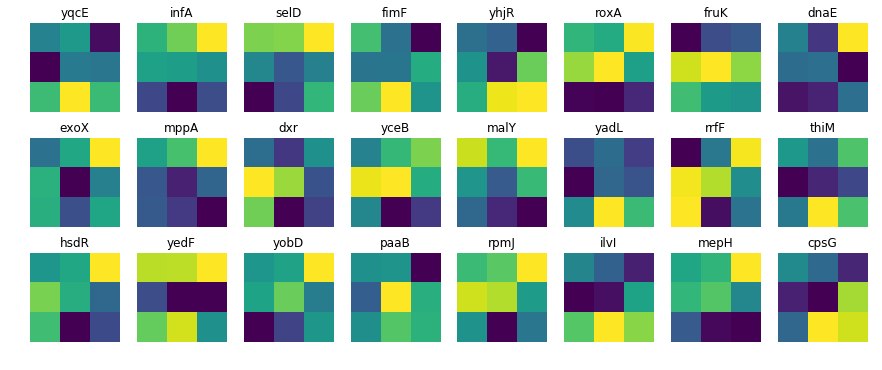

In [8]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=24)
imgs =  X_img[idx]
titles = X_lab[idx]
fig = plt.figure(figsize=(15,6))
p=0
#plt.title("Genomas representados na forma de uma imagem", fontsize=12)
plt.axis("off");
print("----------------------------- Genomas representados na forma de uma matriz -----------------------------")
for i in imgs:
    ax=fig.add_subplot(3,8,p+1)
    plt.title(titles[p])
    plt.imshow(i.reshape(3,3))
    plt.axis("off");
    p += 1

### Dados fake
- Os dados que vão ser passados pro gerador, são dados de uma distribuição normal.
- O gráfico abaixo mostra os dados reais e os dados da distribuição normal os quais são para trenar a rede geradora.

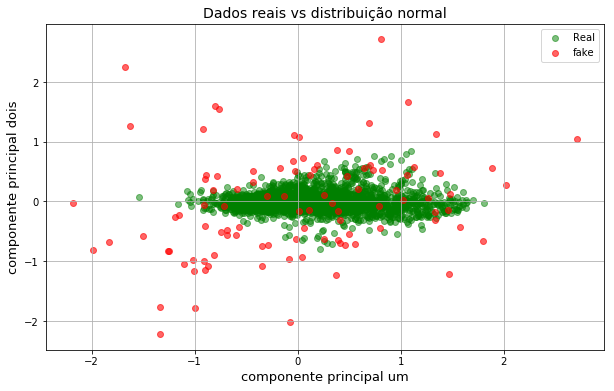

In [10]:
pca2 = PCA(n_components=2)
pca2.fit(X_train)
X_real = pca2.transform(X_train)
X_fake = pca2.transform(np.random.normal(0,1,(100,9)))
plt.figure(figsize=(10,6))
plt.grid()
plt.title("Dados reais vs distribuição normal", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_real[:,0], X_real[:,1], label="Real", alpha=.5, color="green")
plt.scatter(X_fake[:,0], X_fake[:,1], label="fake", alpha=.6, color="red")
plt.legend();

### Construção da GAN
- A GAN conta com dois redes, uma rede geradora e uma discriminadora.

In [99]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        self.g_lpe = []
        self.d_lpe = []
        self.optimizerD = Adam(lr=0.00001, beta_1=0.5)
        self.optimizerG = Adam(lr=0.00004, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizerD, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.stacked_generator_discriminator.add(self.D)
        self.D.trainable = False
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.1))
        model.add(Dense(self.width*self.height*self.channels, activation="tanh"))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Dense(32, input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dropout(.1))
        #model.add(Dense(16))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model

    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        self.g_lpe = []
        self.d_lpe = []
        for cnt in range(epochs):
            batches = self.get_batches(X_train, batch_size)
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%len(batches))==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %f[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))
            self.g_lpe.append(g_l)
            self.d_lpe.append(d_l[0])

In [100]:
noise_input = 100
gan = GANs(width=3, height=3, channels=1, noise_input=noise_input)

Compilando o gerador...
Compilando o discriminador...


In [101]:
print("-----------------------Estrutura da rede generativa-----------------------")
gan.G.summary()

-----------------------Estrutura da rede generativa-----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 9)                 2313      
_________________________________________________________________
reshape_10 (Reshape)         (None, 3, 3, 1)           0         
Total params: 28,169
Trainable params: 28,169
Non-trainable params: 0
_________________________________________________________________


In [102]:
print("-----------------------Estrutura da rede Discriminadora-----------------------")
gan.D.summary()

-----------------------Estrutura da rede Discriminadora-----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 3, 3, 32)          64        
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 289       
Total params: 706
Trainable params: 353
Non-trainable params: 353
_________________________________________________________________


/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [103]:
t_i = time()
gan.train(X_img, epochs=500,batch_size=16)
t_f = time()

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:[1/500] batch:[254/254], [Discriminator::d_loss: 0.755779], [Generator::loss: 0.635355], 3.647618[sec]
epoch:[2/500] batch:[254/254], [Discriminator::d_loss: 0.831479], [Generator::loss: 0.477386], 0.906278[sec]
epoch:[3/500] batch:[254/254], [Discriminator::d_loss: 0.807113], [Generator::loss: 0.487325], 0.764410[sec]
epoch:[4/500] batch:[254/254], [Discriminator::d_loss: 0.805841], [Generator::loss: 0.522199], 0.894170[sec]
epoch:[5/500] batch:[254/254], [Discriminator::d_loss: 0.783941], [Generator::loss: 0.534880], 0.809422[sec]
epoch:[6/500] batch:[254/254], [Discriminator::d_loss: 0.783970], [Generator::loss: 0.572210], 0.793720[sec]
epoch:[7/500] batch:[254/254], [Discriminator::d_loss: 0.764059], [Generator::loss: 0.595302], 0.876623[sec]
epoch:[8/500] batch:[254/254], [Discriminator::d_loss: 0.736215], [Generator::loss: 0.642573], 0.793660[sec]
epoch:[9/500] batch:[254/254], [Discriminator::d_loss: 0.723285], [Generator::loss: 0.626029], 0.760565[sec]
epoch:[10/500] batc

epoch:[76/500] batch:[254/254], [Discriminator::d_loss: 0.694794], [Generator::loss: 0.707807], 0.825842[sec]
epoch:[77/500] batch:[254/254], [Discriminator::d_loss: 0.692379], [Generator::loss: 0.716609], 0.833538[sec]
epoch:[78/500] batch:[254/254], [Discriminator::d_loss: 0.691036], [Generator::loss: 0.692919], 0.804874[sec]
epoch:[79/500] batch:[254/254], [Discriminator::d_loss: 0.696255], [Generator::loss: 0.692434], 0.821287[sec]
epoch:[80/500] batch:[254/254], [Discriminator::d_loss: 0.693851], [Generator::loss: 0.696933], 0.795833[sec]
epoch:[81/500] batch:[254/254], [Discriminator::d_loss: 0.695260], [Generator::loss: 0.701314], 0.832968[sec]
epoch:[82/500] batch:[254/254], [Discriminator::d_loss: 0.690861], [Generator::loss: 0.696860], 0.790916[sec]
epoch:[83/500] batch:[254/254], [Discriminator::d_loss: 0.694509], [Generator::loss: 0.696298], 0.794168[sec]
epoch:[84/500] batch:[254/254], [Discriminator::d_loss: 0.701500], [Generator::loss: 0.691357], 0.796587[sec]
epoch:[85/

epoch:[151/500] batch:[254/254], [Discriminator::d_loss: 0.700206], [Generator::loss: 0.696723], 0.739510[sec]
epoch:[152/500] batch:[254/254], [Discriminator::d_loss: 0.697616], [Generator::loss: 0.704764], 0.741700[sec]
epoch:[153/500] batch:[254/254], [Discriminator::d_loss: 0.696320], [Generator::loss: 0.711618], 0.750395[sec]
epoch:[154/500] batch:[254/254], [Discriminator::d_loss: 0.695787], [Generator::loss: 0.709985], 0.737680[sec]
epoch:[155/500] batch:[254/254], [Discriminator::d_loss: 0.702255], [Generator::loss: 0.685780], 0.741035[sec]
epoch:[156/500] batch:[254/254], [Discriminator::d_loss: 0.702706], [Generator::loss: 0.667214], 0.743864[sec]
epoch:[157/500] batch:[254/254], [Discriminator::d_loss: 0.689729], [Generator::loss: 0.682325], 0.745086[sec]
epoch:[158/500] batch:[254/254], [Discriminator::d_loss: 0.701845], [Generator::loss: 0.688501], 0.735964[sec]
epoch:[159/500] batch:[254/254], [Discriminator::d_loss: 0.704593], [Generator::loss: 0.673889], 0.746259[sec]
e

epoch:[225/500] batch:[254/254], [Discriminator::d_loss: 0.693374], [Generator::loss: 0.689639], 0.755663[sec]
epoch:[226/500] batch:[254/254], [Discriminator::d_loss: 0.692863], [Generator::loss: 0.686355], 0.776016[sec]
epoch:[227/500] batch:[254/254], [Discriminator::d_loss: 0.696713], [Generator::loss: 0.692299], 0.760379[sec]
epoch:[228/500] batch:[254/254], [Discriminator::d_loss: 0.692597], [Generator::loss: 0.708485], 0.754792[sec]
epoch:[229/500] batch:[254/254], [Discriminator::d_loss: 0.694368], [Generator::loss: 0.702889], 0.762903[sec]
epoch:[230/500] batch:[254/254], [Discriminator::d_loss: 0.692578], [Generator::loss: 0.701075], 0.814602[sec]
epoch:[231/500] batch:[254/254], [Discriminator::d_loss: 0.700843], [Generator::loss: 0.673192], 0.760373[sec]
epoch:[232/500] batch:[254/254], [Discriminator::d_loss: 0.695417], [Generator::loss: 0.695794], 0.779092[sec]
epoch:[233/500] batch:[254/254], [Discriminator::d_loss: 0.693410], [Generator::loss: 0.700856], 0.754069[sec]
e

epoch:[299/500] batch:[254/254], [Discriminator::d_loss: 0.691937], [Generator::loss: 0.695155], 0.791233[sec]
epoch:[300/500] batch:[254/254], [Discriminator::d_loss: 0.693266], [Generator::loss: 0.694136], 0.744895[sec]
epoch:[301/500] batch:[254/254], [Discriminator::d_loss: 0.690588], [Generator::loss: 0.679531], 0.747596[sec]
epoch:[302/500] batch:[254/254], [Discriminator::d_loss: 0.689962], [Generator::loss: 0.682601], 0.742219[sec]
epoch:[303/500] batch:[254/254], [Discriminator::d_loss: 0.693862], [Generator::loss: 0.687658], 0.751602[sec]
epoch:[304/500] batch:[254/254], [Discriminator::d_loss: 0.693857], [Generator::loss: 0.692226], 0.739959[sec]
epoch:[305/500] batch:[254/254], [Discriminator::d_loss: 0.698049], [Generator::loss: 0.696988], 0.743718[sec]
epoch:[306/500] batch:[254/254], [Discriminator::d_loss: 0.692000], [Generator::loss: 0.685830], 0.763474[sec]
epoch:[307/500] batch:[254/254], [Discriminator::d_loss: 0.692665], [Generator::loss: 0.672400], 0.762539[sec]
e

epoch:[373/500] batch:[254/254], [Discriminator::d_loss: 0.691827], [Generator::loss: 0.689722], 0.741285[sec]
epoch:[374/500] batch:[254/254], [Discriminator::d_loss: 0.694412], [Generator::loss: 0.686013], 0.738775[sec]
epoch:[375/500] batch:[254/254], [Discriminator::d_loss: 0.688915], [Generator::loss: 0.689757], 0.739536[sec]
epoch:[376/500] batch:[254/254], [Discriminator::d_loss: 0.695477], [Generator::loss: 0.692786], 0.745994[sec]
epoch:[377/500] batch:[254/254], [Discriminator::d_loss: 0.696310], [Generator::loss: 0.692904], 0.743142[sec]
epoch:[378/500] batch:[254/254], [Discriminator::d_loss: 0.693523], [Generator::loss: 0.698901], 0.738742[sec]
epoch:[379/500] batch:[254/254], [Discriminator::d_loss: 0.692090], [Generator::loss: 0.698331], 0.749040[sec]
epoch:[380/500] batch:[254/254], [Discriminator::d_loss: 0.693231], [Generator::loss: 0.694285], 0.740569[sec]
epoch:[381/500] batch:[254/254], [Discriminator::d_loss: 0.692323], [Generator::loss: 0.692646], 0.736831[sec]
e

epoch:[447/500] batch:[254/254], [Discriminator::d_loss: 0.696967], [Generator::loss: 0.678409], 0.743932[sec]
epoch:[448/500] batch:[254/254], [Discriminator::d_loss: 0.691836], [Generator::loss: 0.695200], 0.742878[sec]
epoch:[449/500] batch:[254/254], [Discriminator::d_loss: 0.696499], [Generator::loss: 0.695096], 0.740581[sec]
epoch:[450/500] batch:[254/254], [Discriminator::d_loss: 0.698032], [Generator::loss: 0.692707], 0.740423[sec]
epoch:[451/500] batch:[254/254], [Discriminator::d_loss: 0.696336], [Generator::loss: 0.694124], 0.742004[sec]
epoch:[452/500] batch:[254/254], [Discriminator::d_loss: 0.691198], [Generator::loss: 0.682405], 0.738111[sec]
epoch:[453/500] batch:[254/254], [Discriminator::d_loss: 0.695867], [Generator::loss: 0.692316], 0.736404[sec]
epoch:[454/500] batch:[254/254], [Discriminator::d_loss: 0.696461], [Generator::loss: 0.691465], 0.749671[sec]
epoch:[455/500] batch:[254/254], [Discriminator::d_loss: 0.693298], [Generator::loss: 0.686884], 0.809928[sec]
e

In [104]:
print("tempo de execução: ", (t_f-t_i)/60, "[min]")

tempo de execução:  6.586930505434672 [min]


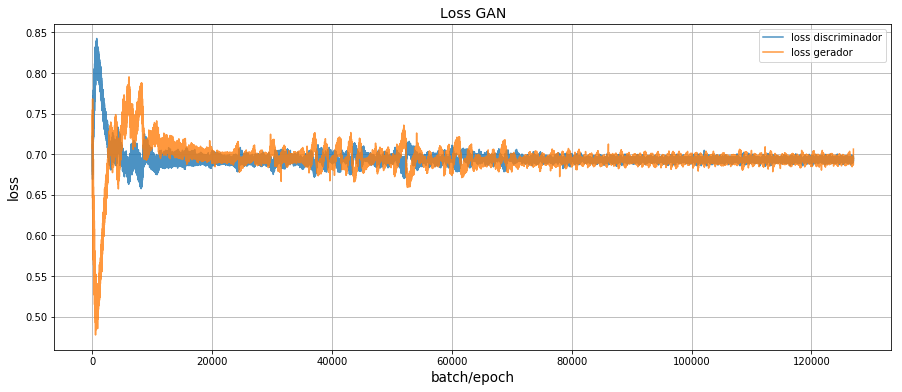

In [105]:
g_loss, d_loss = gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador", alpha=.8)
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador", alpha=.8)
#plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

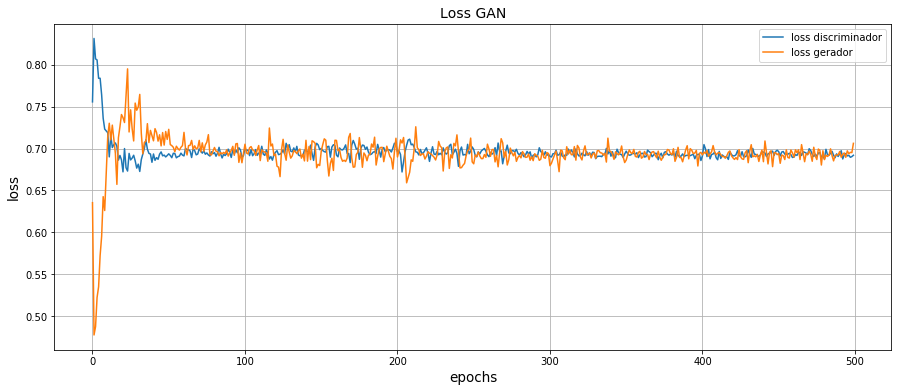

In [106]:
plt.figure(figsize=(15,6))
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("epochs", fontsize=13.5)
plt.plot(range(len(gan.d_lpe)), np.array(gan.d_lpe), label="loss discriminador")
plt.plot(range(len(gan.g_lpe)), np.array(gan.g_lpe), label="loss gerador")
#plt.plot(range(len(gan.g_lpe)), 0.5*np.ones(len(gan.g_lpe)),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.legend();

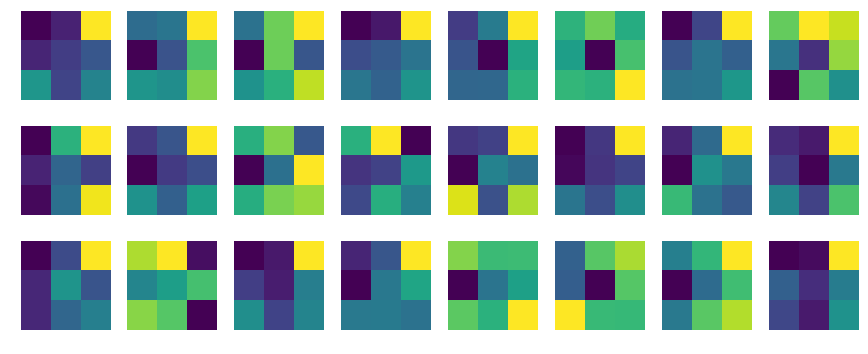

In [107]:
num_imgs = 24 #número de imágenes a mostrar aleatoriamente
img_pre = gan.G.predict(np.random.normal(0,1,(num_imgs, noise_input)))
fig = plt.figure(figsize=(15,6))
for i in range(num_imgs):
    ax=fig.add_subplot(3,8,i+1)
    img = img_pre[i]
    plt.imshow(img.reshape((3,3)))
    ax.axis("off")
plt.show()

In [108]:
num_imgs = 300
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,noise_input)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)

imagens fake:  (300, 3, 3, 1)
re-dimesionalidade:  (300, 9)


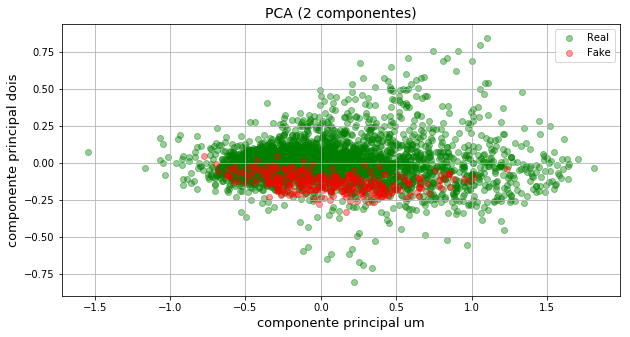

In [109]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();

- matrix de confução para cada par de caracteristicas
- ver quais pontos o discriminador dize que são reais e quais não.